# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [65]:

# The business task is to build a regression model to predict used car prices. This involves identifying and selecting relevant features
# from the provided dataset that are statistically significant predictors of price, and evaluating the model's performance using appropriate
# metrics such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE).

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [66]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")
print("All files loaded")

All files loaded


In [67]:
df = pd.read_csv('sample_data/vehicles.csv')

In [68]:
df.shape

(426880, 18)

In [69]:
df.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [70]:

df['price'].describe()

,price
count,426880.000
mean,75199.033
std,12182282.174
min,0.000
25%,5900.000
50%,13950.000
75%,26485.750
max,3736928711.000


In [71]:
# look at the price column

df['price']

,price
0,6000
1,11900
2,21000
3,1500
4,4900
...,...
426875,23590
426876,30590
426877,34990
426878,28990


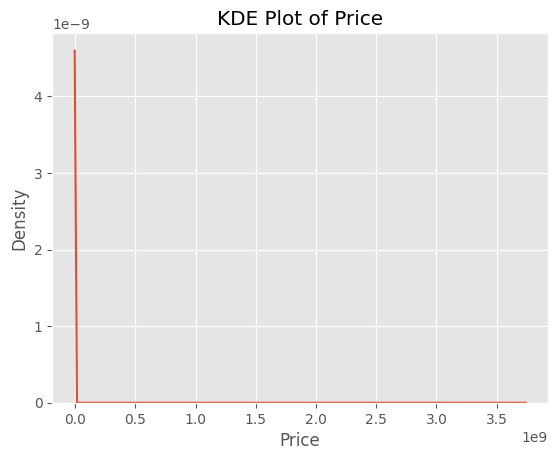

In [72]:
sns.kdeplot(df['price'])
plt.title('KDE Plot of Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

Original shape: (426880, 18)
Shape after dropping outliers: (418703, 18)


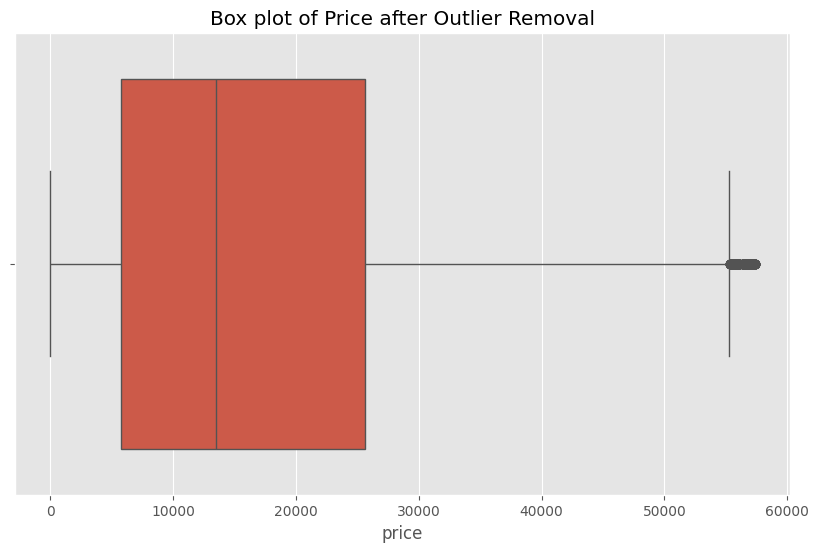

In [73]:
# drop the oulier in the price column

# Identify the lower and upper bounds for outliers in the 'price' column
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Drop rows where 'price' is outside the calculated bounds
df_cleaned = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)].copy()
df['price'] = df_cleaned['price']

# Display the shape of the dataframe before and after dropping outliers
print(f"Original shape: {df.shape}")
print(f"Shape after dropping outliers: {df_cleaned.shape}")

# Optionally, visualize the price distribution after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title('Box plot of Price after Outlier Removal')
plt.show()

In [74]:
df['price'].describe()

,price
count,418703.000
mean,16342.803
std,13148.416
min,0.000
25%,5799.000
50%,13495.000
75%,25590.000
max,57341.000


In [75]:
# plot the kde of price using plotly

import plotly.express as px

fig = px.histogram(df, x="price", nbins=100)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [76]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df['price'].describe([0.0,0.1,0.2,0.3,0.5,.06,.07,0.8,0.85,.09,0.95]).round(2)

,price
count,418703.000
mean,16342.800
std,13148.420
min,0.000
0%,0.000
6%,0.000
7%,0.000
9%,199.000
10%,485.000
20%,4495.000


In [77]:
# Convert the manufacturer into top 10

# Convert 'manufacturer' to top 10 and group the rest as 'Other'
top_10_manufacturers = df['manufacturer'].value_counts().nlargest(10).index.tolist()
df['manufacturer'] = df['manufacturer'].apply(lambda x: x if x in top_10_manufacturers else 'Other')

# Display the value counts of the new 'manufacturer' column to verify
print(df['manufacturer'].value_counts())

manufacturer
Other        143746
ford          70985
chevrolet     55064
toyota        34202
honda         21269
nissan        19067
jeep          19014
ram           18342
gmc           16785
bmw           14699
dodge         13707
Name: count, dtype: int64


In [78]:
# Convert the model into top 10

# Convert 'model' to top 10 and group the rest as 'Other'
top_10_models = df['model'].value_counts().nlargest(10).index.tolist()
df['model'] = df['model'].apply(lambda x: x if x in top_10_models else 'Other')

# Display the value counts of the new 'model' column to verify
print(df['model'].value_counts())

model
Other             389221
f-150               8009
silverado 1500      5140
1500                4211
camry               3135
silverado           3023
accord              2969
wrangler            2848
civic               2799
altima              2779
escape              2746
Name: count, dtype: int64


In [79]:
# Convert the region to the 10 top

# convert region to the top 10
top_10_regions = df['region'].value_counts().nlargest(10).index

df['region'] = df['region'].apply(lambda x: x if x in top_10_regions else 'Other')

# Display the value counts to verify the change
print(df['region'].value_counts())

region
Other                       395845
columbus                      3608
jacksonville                  3562
spokane / coeur d'alene       2988
eugene                        2985
fresno / madera               2983
orlando                       2983
omaha / council bluffs        2982
bend                          2982
new hampshire                 2981
kennewick-pasco-richland      2981
Name: count, dtype: int64


In [80]:
# Drop vin column

df = df.drop(columns=['VIN'])

In [81]:
# Convert the color to the 10 top

# convert color to the top 10
top_10_colors = df['paint_color'].value_counts().nlargest(10).index

df['paint_color'] = df['paint_color'].apply(lambda x: x if x in top_10_colors else 'Other')

# Display the value counts to verify the change
print(df['paint_color'].value_counts())

paint_color
Other     132874
white      79285
black      62861
silver     42970
blue       31223
red        30473
grey       24416
green       7343
custom      6700
brown       6593
yellow      2142
Name: count, dtype: int64


In [82]:
# Convert type to top 10

# convert type to the top 10
top_10_types = df['type'].value_counts().nlargest(10).index

df['type'] = df['type'].apply(lambda x: x if x in top_10_types else 'Other')

# Display the value counts to verify the change
print(df['type'].value_counts())



type
Other          98809
sedan          87056
SUV            77284
pickup         43510
truck          35279
other          22110
coupe          19204
hatchback      16598
wagon          10751
van             8548
convertible     7731
Name: count, dtype: int64


In [83]:
# Convert the State to top 10

# convert State to the top 10
top_10_states = df['state'].value_counts().nlargest(10).index

df['state'] = df['state'].apply(lambda x: x if x in top_10_states else 'Other')

# Display the value counts to verify the change
print(df['state'].value_counts())

state
Other    210833
ca        50614
fl        28511
tx        22945
ny        19386
oh        17696
or        17104
mi        16900
nc        15277
wa        13861
pa        13753
Name: count, dtype: int64


In [84]:
df.select_dtypes(include=['object']).agg(['nunique'])

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state
nunique,11,11,11,6,8,5,6,3,3,4,11,11,11


In [85]:
#  Convert the year into age

df['age'] = 2024 - df['year']
df['age'] = df['age'].dropna()

In [86]:
# Convert the sylinders column to integers

df['cylinders'] = df['cylinders'].astype(str).str.extract('(\d+)').astype(float)
df['cylinders'] = df['cylinders'].fillna(df['cylinders'].median())
df['cylinders'] = df['cylinders'].astype(int)
df['cylinders']

,cylinders
0,6
1,6
2,6
3,6
4,6
...,...
426875,6
426876,6
426877,6
426878,6


In [87]:
# Drop nan value

df = df.dropna()
df.shape

(90599, 18)

In [88]:
df

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,age
31,7316356412,Other,15000.000,2013.000,ford,Other,excellent,6,gas,128000.000,clean,automatic,rwd,full-size,truck,black,Other,11.000
55,7314560853,Other,19900.000,2004.000,ford,Other,good,8,diesel,88000.000,clean,automatic,4wd,full-size,pickup,blue,Other,20.000
59,7313406529,Other,14000.000,2012.000,honda,Other,excellent,6,gas,95000.000,clean,automatic,fwd,full-size,Other,silver,Other,12.000
65,7312847466,Other,22500.000,2001.000,ford,Other,good,8,diesel,144700.000,clean,manual,rwd,full-size,truck,white,Other,23.000
73,7312144944,Other,15000.000,2017.000,dodge,Other,excellent,8,gas,90000.000,rebuilt,automatic,rwd,mid-size,sedan,grey,Other,7.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426809,7302963273,Other,18000.000,1990.000,jeep,Other,good,8,gas,114400.000,clean,automatic,4wd,full-size,SUV,black,Other,34.000
426831,7302384818,Other,9800.000,1985.000,nissan,Other,like new,6,gas,115000.000,clean,automatic,rwd,sub-compact,hatchback,red,Other,39.000
426833,7302338378,Other,6800.000,1997.000,Other,Other,good,8,gas,69550.000,clean,automatic,rwd,compact,convertible,white,Other,27.000
426836,7302301268,Other,0.000,2018.000,ram,Other,excellent,6,diesel,20492.000,clean,automatic,4wd,full-size,truck,white,Other,6.000


In [89]:
# Split the df data into testing and train use shuffle function

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

Training data shape: (72479, 17)
Testing data shape: (18120, 17)
Training target shape: (72479,)
Testing target shape: (18120,)


              id   year  cylinders  odometer    age  region_bend  \
id         1.000 -0.031     -0.033    -0.012  0.031        0.015   
year      -0.031  1.000     -0.203    -0.078 -1.000       -0.007   
cylinders -0.033 -0.203      1.000     0.042  0.203        0.002   
odometer  -0.012 -0.078      0.042     1.000  0.078       -0.005   
age        0.031 -1.000      0.203     0.078  1.000        0.007   
...          ...    ...        ...       ...    ...          ...   
state_oh  -0.063  0.007     -0.033    -0.006 -0.007       -0.013   
state_or   0.034 -0.022     -0.035     0.004  0.022        0.336   
state_pa  -0.024 -0.017     -0.029    -0.002  0.017       -0.011   
state_tx   0.044  0.008      0.017     0.002 -0.008       -0.013   
state_wa   0.035 -0.052     -0.007     0.005  0.052       -0.007   

           region_columbus  region_eugene  region_fresno / madera  \
id                  -0.024          0.026                   0.041   
year                -0.004         -0.002    

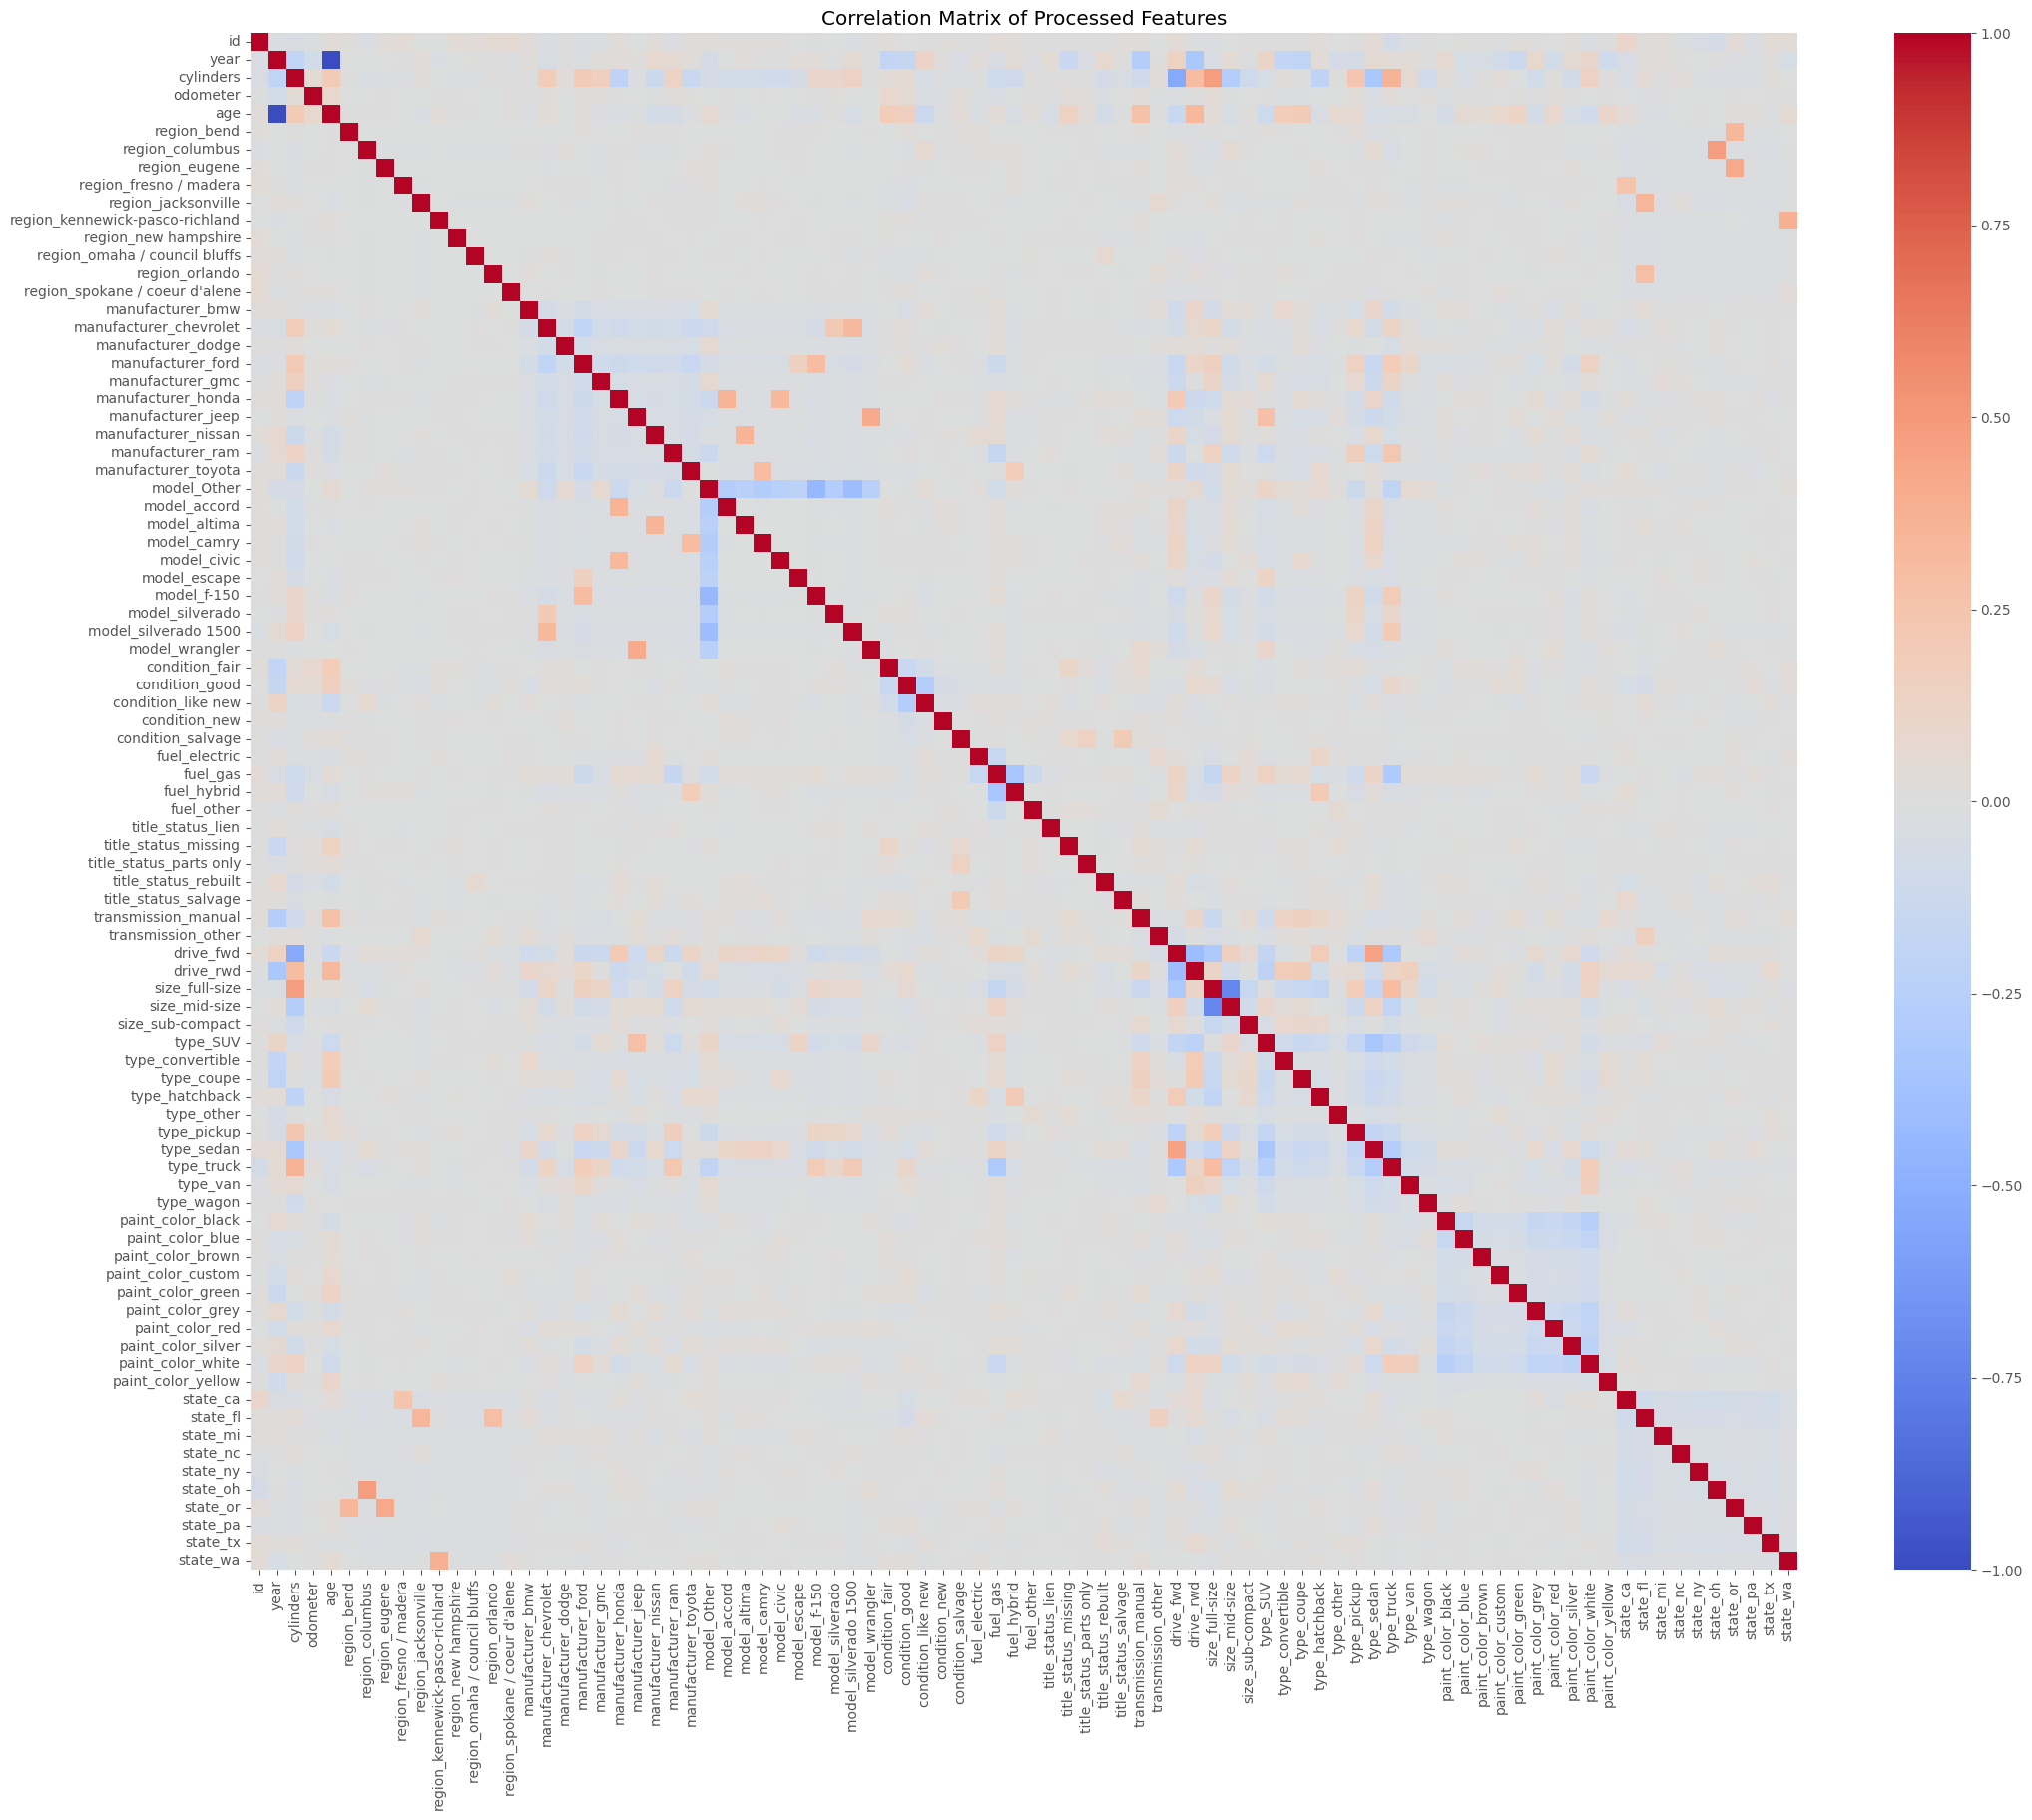


Correlation with Price:
 price               1.000
fuel_electric       0.022
model_Other         0.021
type_convertible    0.021
title_status_lien   0.014
                     ... 
state_oh              NaN
state_or              NaN
state_pa              NaN
state_tx              NaN
state_wa              NaN
Name: price, Length: 87, dtype: float64


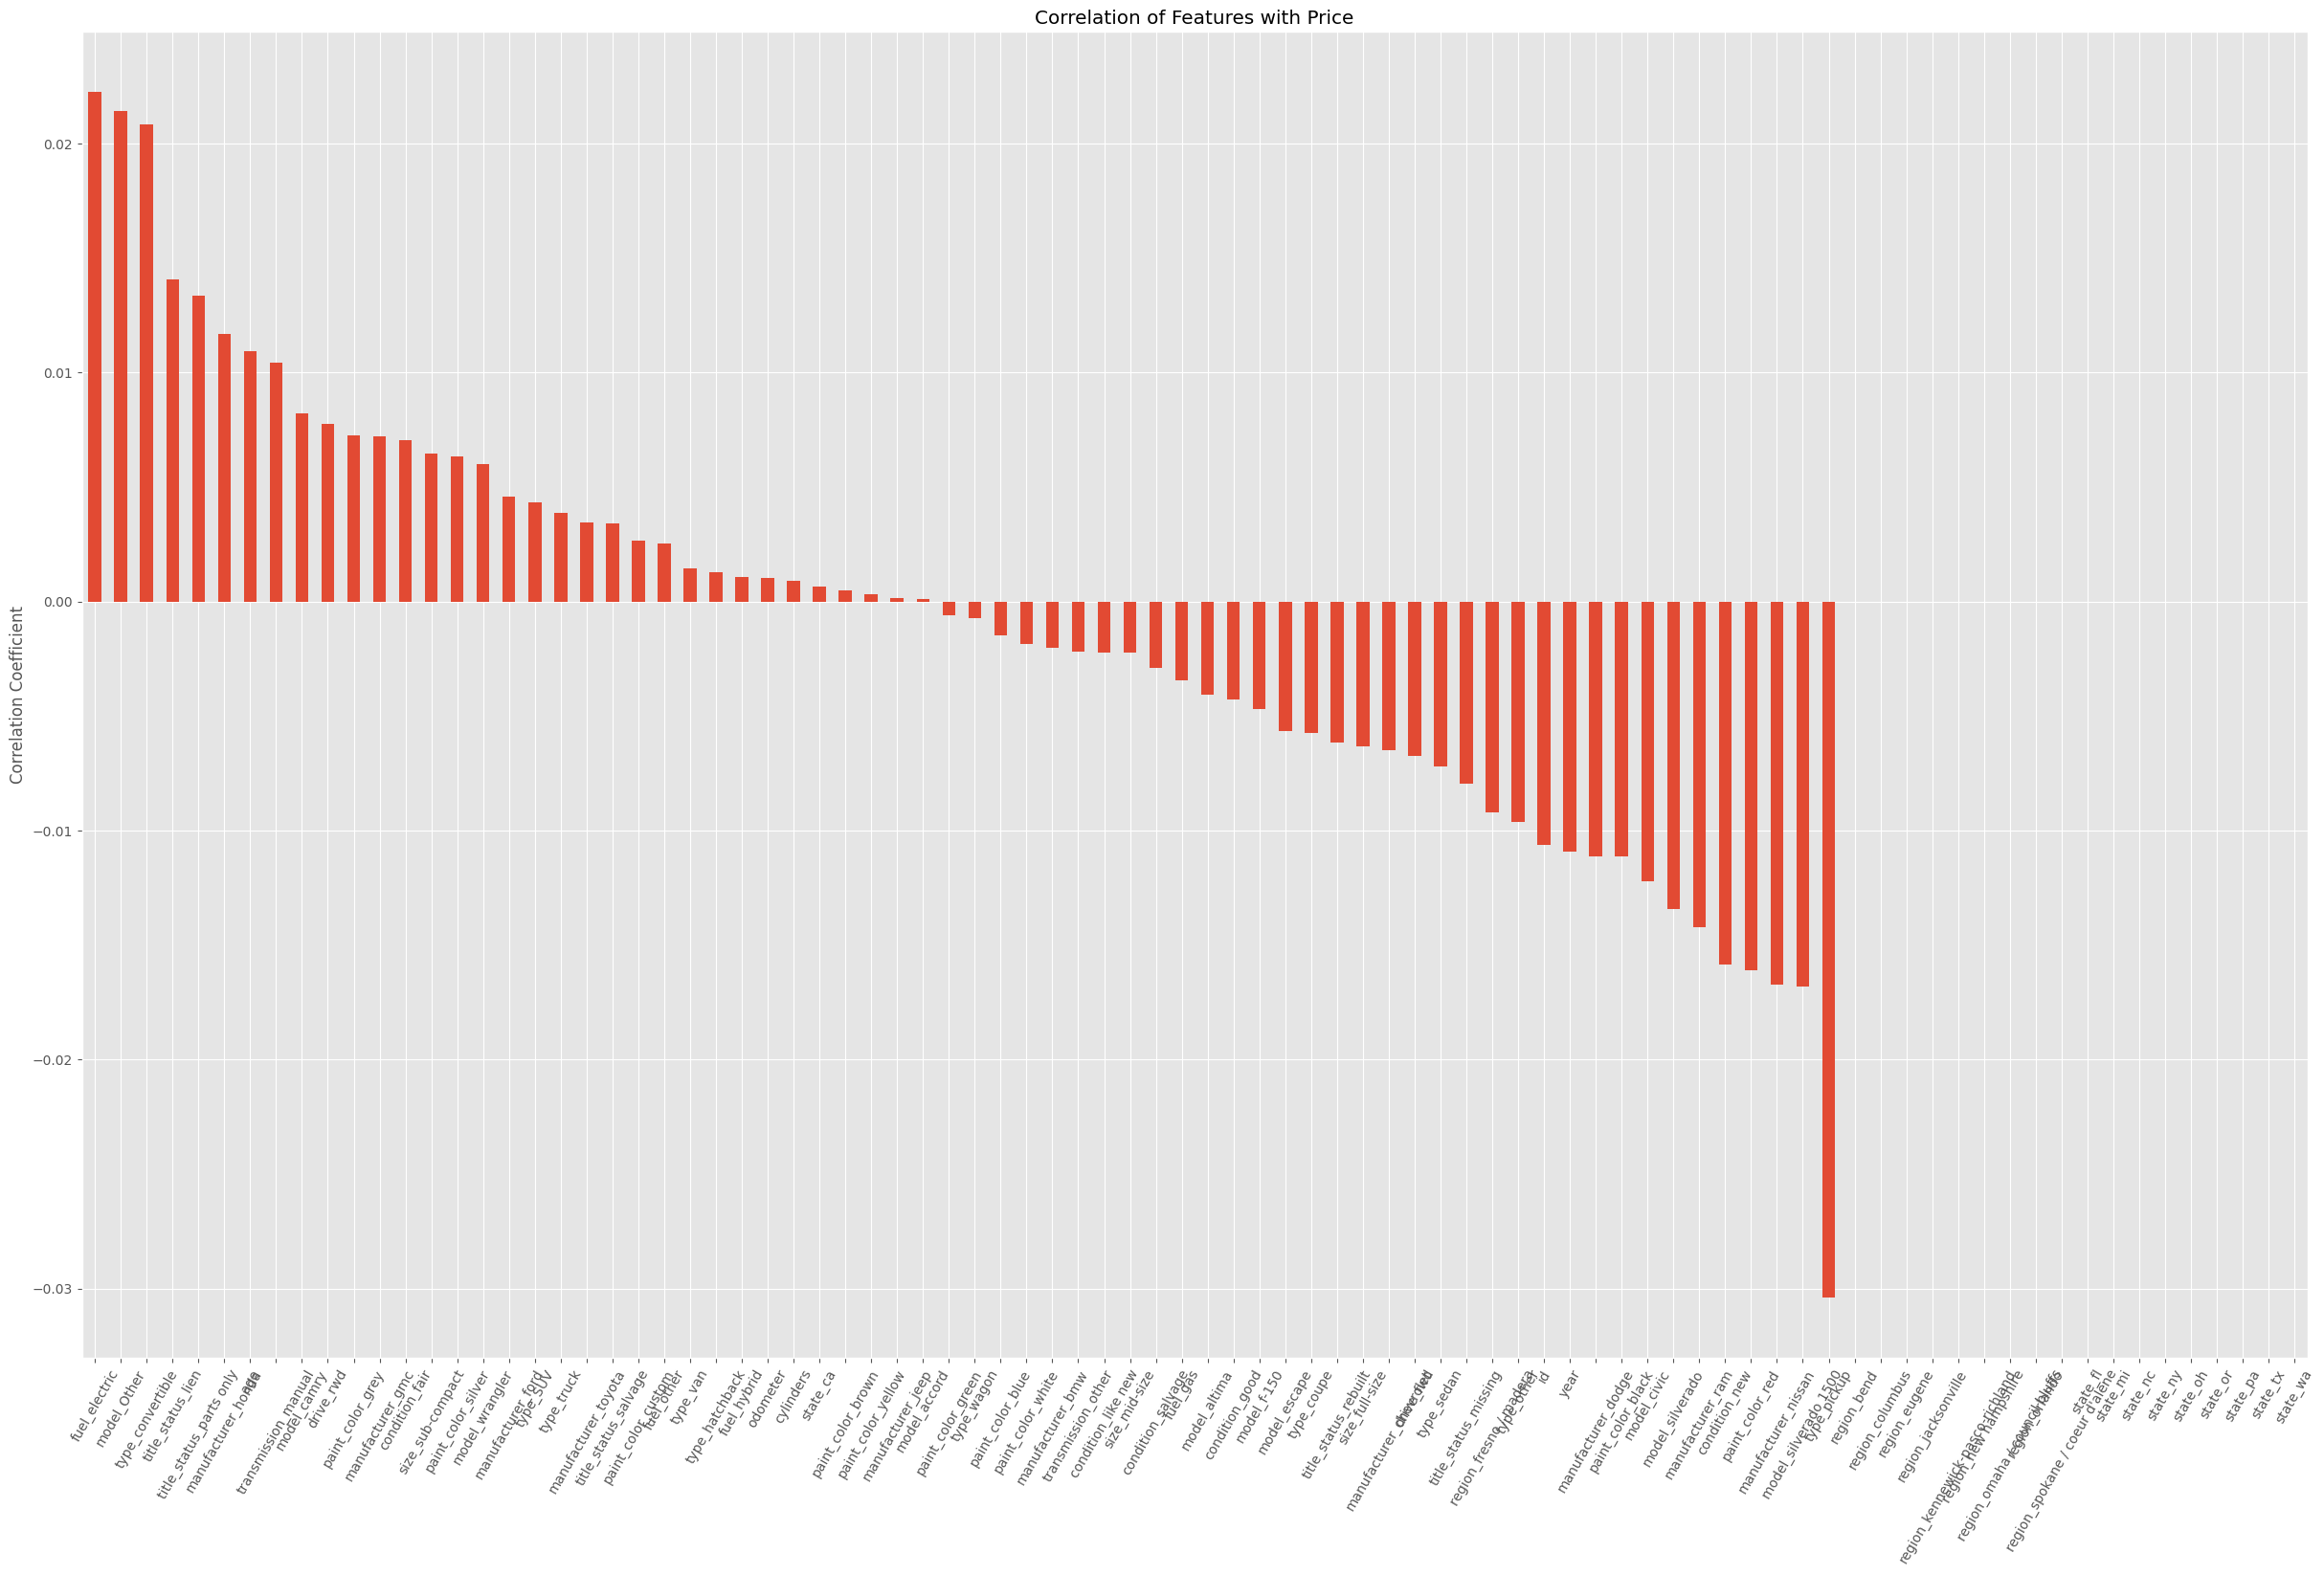

In [90]:
# Use corr with categorical features

# Identify categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(include=np.number).columns

# Use get_dummies to one-hot encode categorical features in the training data
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)

# Ensure alignment of columns with test set after encoding

X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
X_test_encoded = X_test_encoded.reindex(columns = X_train_encoded.columns, fill_value=0)



# Calculate the correlation matrix for the processed training data
correlation_matrix = X_train_encoded.corr()

# Print the correlation matrix (optional, can be large)
print(correlation_matrix)

# To visualize the correlation matrix, you can use a heatmap
plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Processed Features')
plt.show()


train_data_corr = pd.concat([X_train_encoded, y_train.reset_index(drop=True)], axis=1)

# Calculate correlation with the target variable
correlation_with_price = train_data_corr.corr()['price'].sort_values(ascending=False)

# Print the correlations with the target variable
print("\nCorrelation with Price:\n", correlation_with_price)

# Visualize the correlations with the target variable
plt.figure(figsize=(30, 18))
correlation_with_price.drop('price').plot(kind='bar')
plt.title('Correlation of Features with Price')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=60)
plt.show()

In [91]:
df

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,age
31,7316356412,Other,15000.000,2013.000,ford,Other,excellent,6,gas,128000.000,clean,automatic,rwd,full-size,truck,black,Other,11.000
55,7314560853,Other,19900.000,2004.000,ford,Other,good,8,diesel,88000.000,clean,automatic,4wd,full-size,pickup,blue,Other,20.000
59,7313406529,Other,14000.000,2012.000,honda,Other,excellent,6,gas,95000.000,clean,automatic,fwd,full-size,Other,silver,Other,12.000
65,7312847466,Other,22500.000,2001.000,ford,Other,good,8,diesel,144700.000,clean,manual,rwd,full-size,truck,white,Other,23.000
73,7312144944,Other,15000.000,2017.000,dodge,Other,excellent,8,gas,90000.000,rebuilt,automatic,rwd,mid-size,sedan,grey,Other,7.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426809,7302963273,Other,18000.000,1990.000,jeep,Other,good,8,gas,114400.000,clean,automatic,4wd,full-size,SUV,black,Other,34.000
426831,7302384818,Other,9800.000,1985.000,nissan,Other,like new,6,gas,115000.000,clean,automatic,rwd,sub-compact,hatchback,red,Other,39.000
426833,7302338378,Other,6800.000,1997.000,Other,Other,good,8,gas,69550.000,clean,automatic,rwd,compact,convertible,white,Other,27.000
426836,7302301268,Other,0.000,2018.000,ram,Other,excellent,6,diesel,20492.000,clean,automatic,4wd,full-size,truck,white,Other,6.000


In [92]:
# Use onehot code to include all the categorical features

# Select only the object type columns for one-hot encoding
categorical_features = X_train.select_dtypes(include=['object']).columns

# Apply one-hot encoding to the selected categorical features in both train and test sets
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)


X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='inner', axis=1, fill_value=0)

print("Shape of X_train after one-hot encoding:", X_train_encoded.shape)
print("Shape of X_test after one-hot encoding:", X_test_encoded.shape)


Shape of X_train after one-hot encoding: (72479, 86)
Shape of X_test after one-hot encoding: (18120, 86)


In [93]:
X_train_encoded.replace({True: 1, False: 0}, inplace=True)

In [94]:
X_train_encoded

,id,year,cylinders,odometer,age,region_bend,region_columbus,region_eugene,region_fresno / madera,region_jacksonville,...,state_ca,state_fl,state_mi,state_nc,state_ny,state_oh,state_or,state_pa,state_tx,state_wa
286246,7303233109,2016.000,4,61127.000,8.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136796,7315525566,2000.000,6,107000.000,24.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242674,7309457284,2008.000,6,206421.000,16.000,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
94899,7313090431,1997.000,8,119000.000,27.000,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
396301,7313710330,2013.000,4,122350.000,11.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31415,7315018588,2009.000,6,133781.000,15.000,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
259603,7315849539,2002.000,8,230000.000,22.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
355331,7310994328,2010.000,4,30958.000,14.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4379,7303011856,2006.000,6,220000.000,18.000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


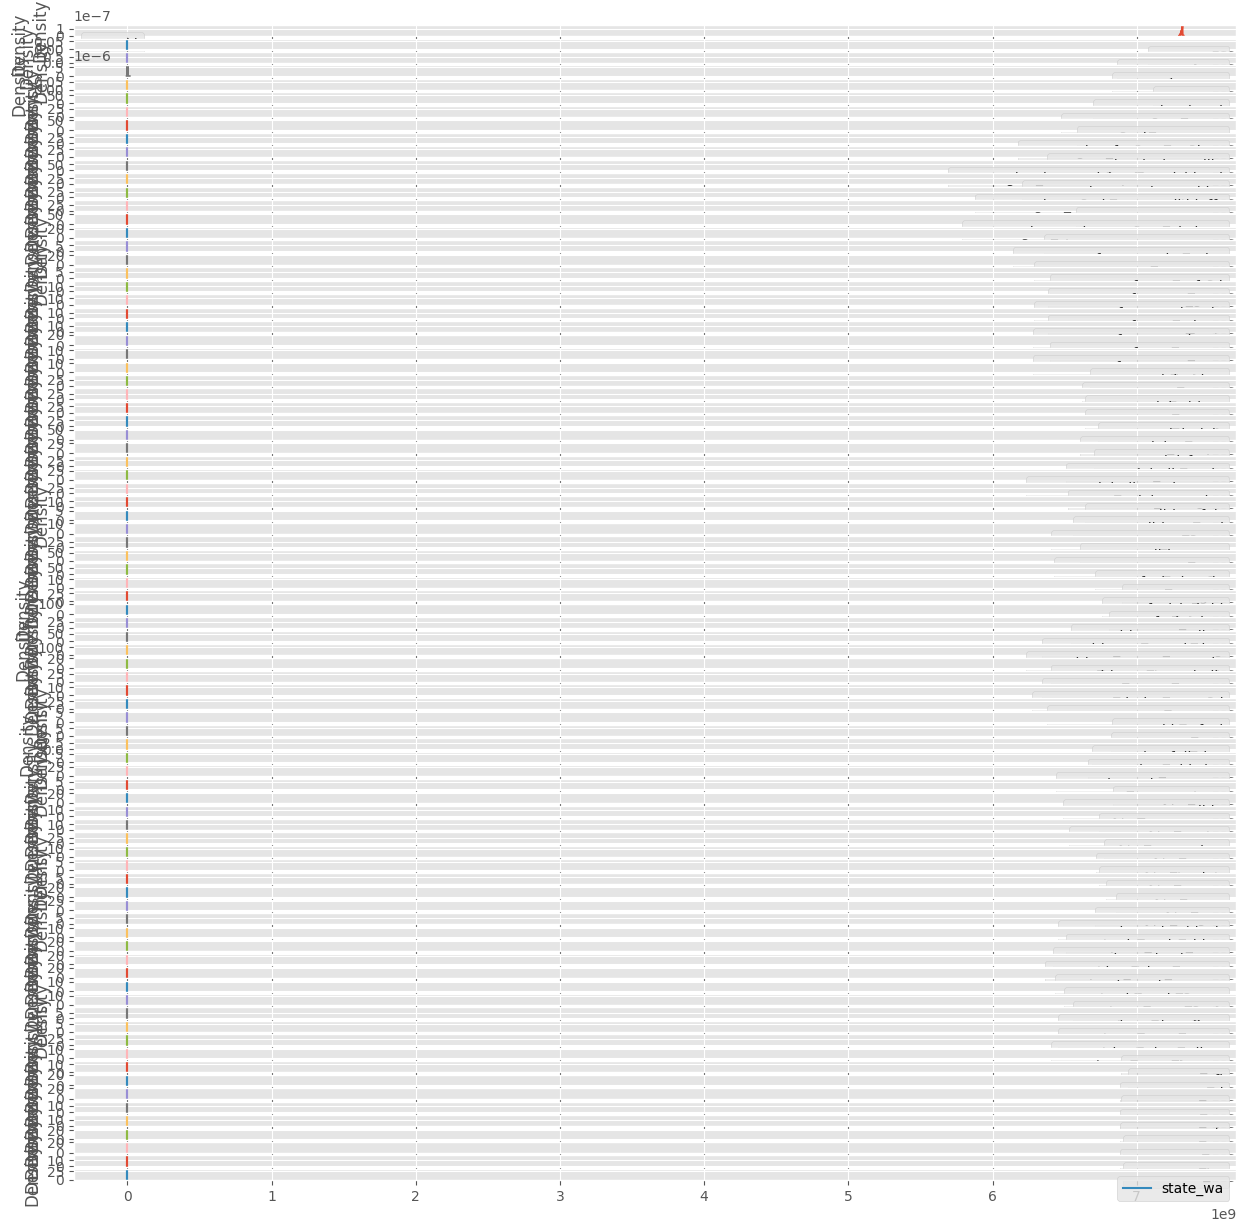

In [95]:
X_train_encoded.plot(kind = 'kde', subplots = True, figsize = (15, 15))
plt.show()

In [96]:
# Creating the scaled version which will be updated


X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()




# intiate the Standard Scaler
scale = StandardScaler()

# fit transform on the train data
X_train_scaled[:] = scale.fit_transform(X_train_encoded[:])

# Test data
X_test_scaled[:] = scale.transform(X_test_encoded[:])





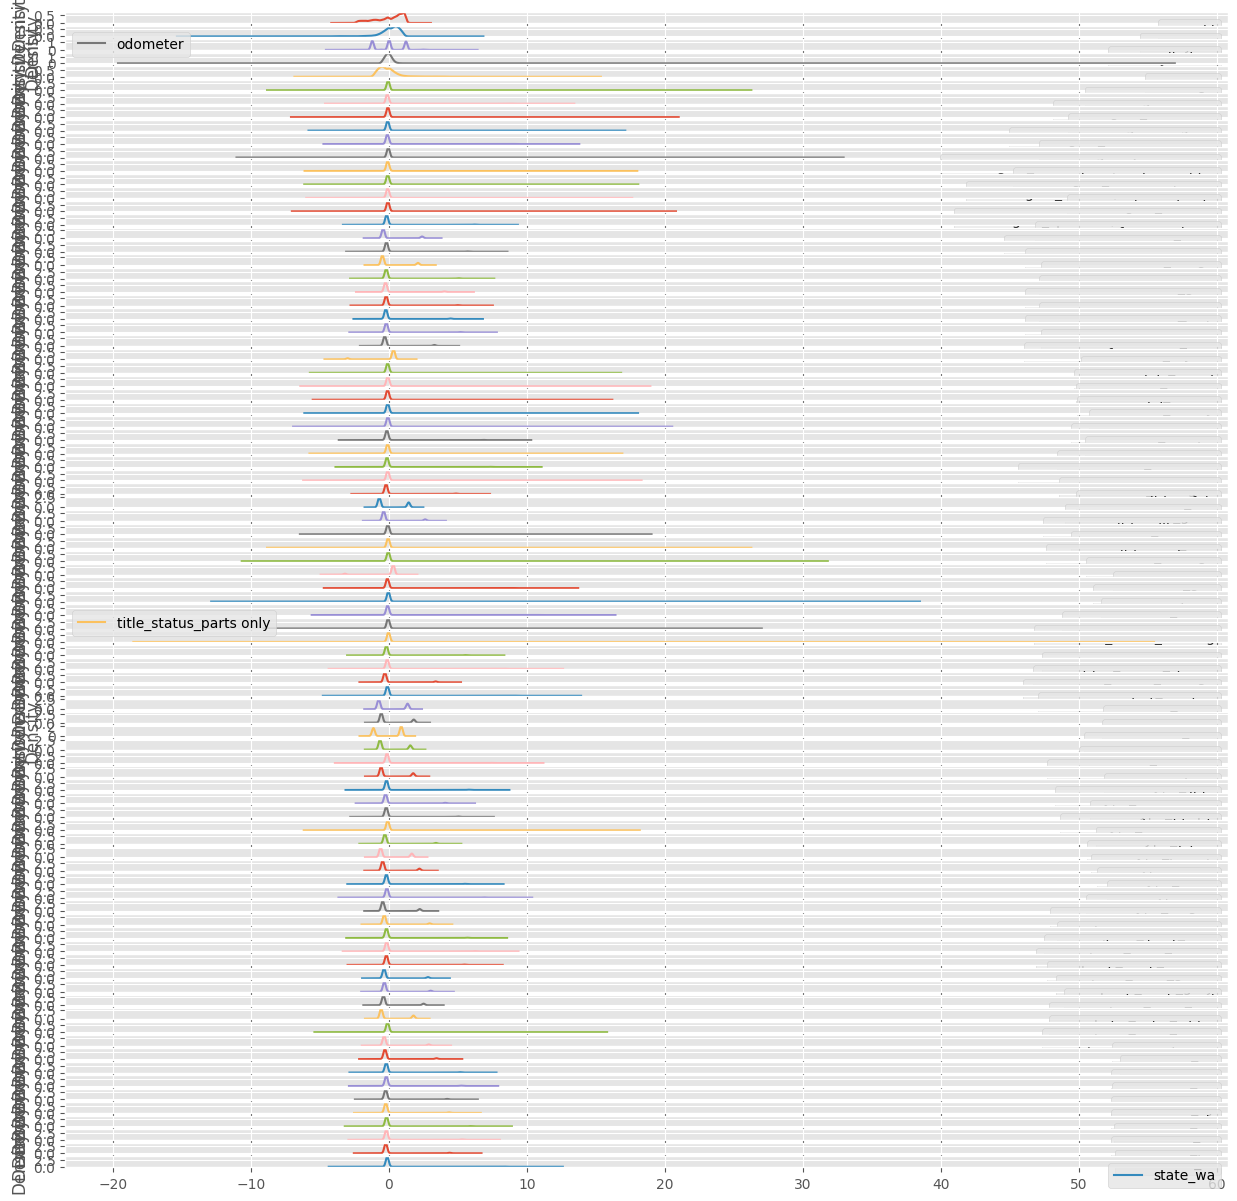

In [97]:
X_train_scaled.plot(kind = 'kde', subplots = True, figsize = (15, 15))
plt.show()

In [98]:
X_train_scaled.agg(["mean", "std"]).round(1)

,id,year,cylinders,odometer,age,region_bend,region_columbus,region_eugene,region_fresno / madera,region_jacksonville,...,state_ca,state_fl,state_mi,state_nc,state_ny,state_oh,state_or,state_pa,state_tx,state_wa
mean,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,...,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [99]:
# Use linear model predict

# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluate the Linear Regression model
rmse_linear = root_mean_squared_error(y_test, y_pred_linear)


print(f"Linear Regression - RMSE: {rmse_linear:.4f}")



Linear Regression - RMSE: 8794.7748


In [100]:
# Use lasso

# Initialize and train the Lasso Regression model
lasso_model = Lasso(alpha=1.0)  # You can adjust the alpha parameter (regularization strength)
lasso_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Evaluate the Lasso Regression model
rmse_lasso = root_mean_squared_error(y_test, y_pred_lasso)


print(f"Lasso Regression - RMSE: {rmse_lasso:.4f}")


lasso_coefficients = pd.DataFrame({'feature': X_train_scaled.columns, 'coefficient': lasso_model.coef_})
lasso_coefficients = lasso_coefficients[lasso_coefficients['coefficient'] != 0].sort_values('coefficient', ascending=False)

print("\nLasso Coefficients (Non-Zero):")
lasso_coefficients

Lasso Regression - RMSE: 8794.9099

Lasso Coefficients (Non-Zero):


,feature,coefficient
1,year,1965.564
63,type_truck,1611.218
25,model_Other,1201.859
53,size_full-size,1149.630
37,condition_like new,1130.901
...,...,...
3,odometer,-1049.811
36,condition_good,-1325.530
35,condition_fair,-1479.446
51,drive_fwd,-1938.930


In [110]:
y_pred_ensemble_average = (y_pred_linear + y_pred_lasso) / 2

# Evaluate the ensemble model
rmse_ensemble_average = root_mean_squared_error(y_test, y_pred_ensemble_average)

print(f"\nEnsemble (Average) RMSE: {rmse_ensemble_average:.2f}")


# Compare with the Linear and Lasso models
print(f"\nLinear Regression RMSE: {rmse_linear:.2f}")
print(f"Lasso Regression RMSE: {rmse_lasso:.2f}")


if rmse_ensemble_average < min(rmse_linear, rmse_lasso):
    print("Ensemble (Average) performs better than individual models and baseline.")
elif rmse_ensemble_average < rmse_linear and rmse_ensemble_average < rmse_lasso:
     print("Ensemble (Average) performs better than individual models.")
elif rmse_ensemble_average < rmse_linear:
    print("Ensemble (Average) performs better than Linear Regression.")
elif rmse_ensemble_average < rmse_lasso:
    print("Ensemble (Average) performs better than Lasso Regression.")





Ensemble (Average) RMSE: 8794.84

Linear Regression RMSE: 8794.77
Lasso Regression RMSE: 8794.91
Ensemble (Average) performs better than Lasso Regression.


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [102]:
y_test.mean()

np.float64(12450.526821192054)

In [103]:
# What is the test vs train RMSE

# Predict on the training set to get training RMSE
y_pred_train_linear = linear_model.predict(X_train_scaled)
rmse_train_linear = root_mean_squared_error(y_train, y_pred_train_linear)


# y_pred_linear = linear_model.predict(X_test_scaled)
# rmse_linear = root_mean_squared_error(y_test, y_pred_linear)

print(f"Linear Regression - Training RMSE: {rmse_train_linear:.4f}")
print(f"Linear Regression - Test RMSE: {rmse_linear:.4f}")

# Predict on the training set to get training RMSE for Lasso
y_pred_train_lasso = lasso_model.predict(X_train_scaled)
rmse_train_lasso = root_mean_squared_error(y_train, y_pred_train_lasso)


# y_pred_lasso = lasso_model.predict(X_test_scaled)
# rmse_lasso = root_mean_squared_error(y_test, y_pred_lasso)

print(f"Lasso Regression - Training RMSE: {rmse_train_lasso:.4f}")
print(f"Lasso Regression - Test RMSE: {rmse_lasso:.4f}")

Linear Regression - Training RMSE: 8832.1756
Linear Regression - Test RMSE: 8794.7748
Lasso Regression - Training RMSE: 8832.1958
Lasso Regression - Test RMSE: 8794.9099


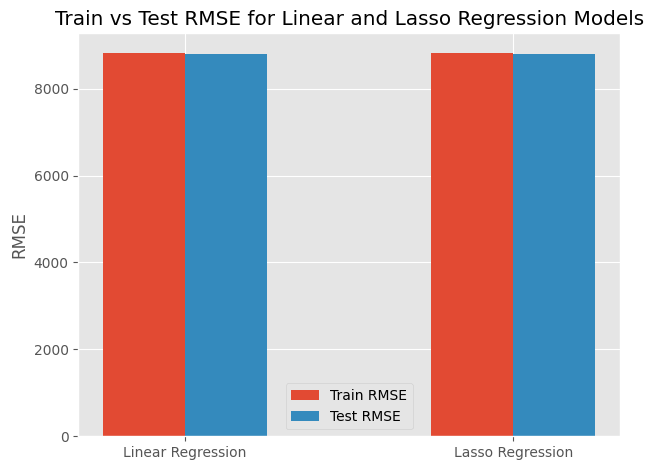

In [116]:
# Use bar plot to visualize the comparison

# Simple plot for comparison of test vs train RMSE
models = ['Linear Regression', 'Lasso Regression']
train_rmses = [rmse_train_linear, rmse_train_lasso]
test_rmses = [rmse_linear, rmse_lasso]

x = np.arange(len(models))
width = 0.25 # width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_rmses, width, label='Train RMSE')
rects2 = ax.bar(x + width/2, test_rmses, width, label='Test RMSE')

ax.set_ylabel('RMSE')
ax.set_title('Train vs Test RMSE for Linear and Lasso Regression Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()
plt.show()

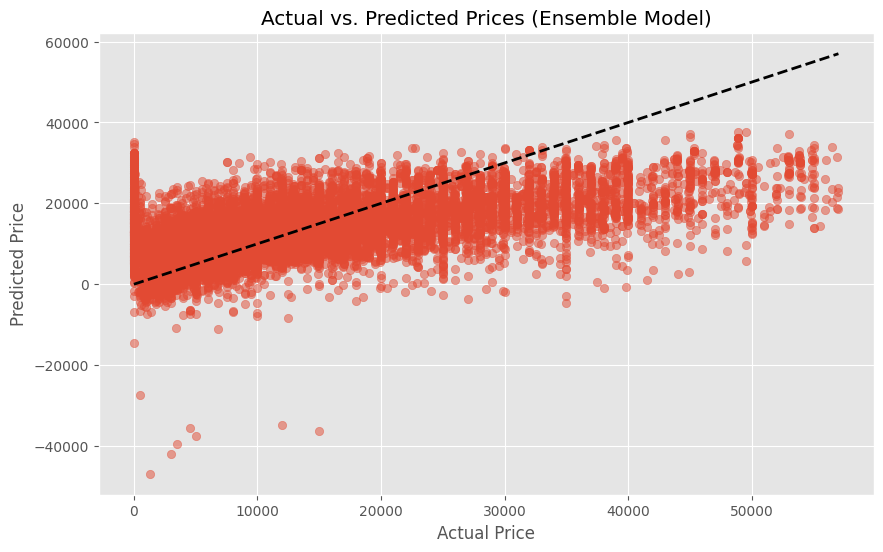

In [117]:
#

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ensemble_average, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices (Ensemble Model)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.grid(True)
plt.show()


Comparison of Coefficients:
               feature  Linear Regression Coefficient  \
41            fuel_gas                      -2243.426   
51           drive_fwd                      -1940.561   
63          type_truck                       1609.387   
35      condition_fair                      -1480.445   
36      condition_good                      -1326.750   
..                 ...                            ...   
6      region_columbus                         -9.854   
40       fuel_electric                         -8.711   
70   paint_color_green                          6.486   
60          type_other                         -3.766   
20  manufacturer_honda                          1.208   

    Lasso Regression Coefficient  
41                     -2243.788  
51                     -1938.930  
63                      1611.218  
35                     -1479.446  
36                     -1325.530  
..                           ...  
6                         -9.140  
40    

<Figure size 1500x1000 with 0 Axes>

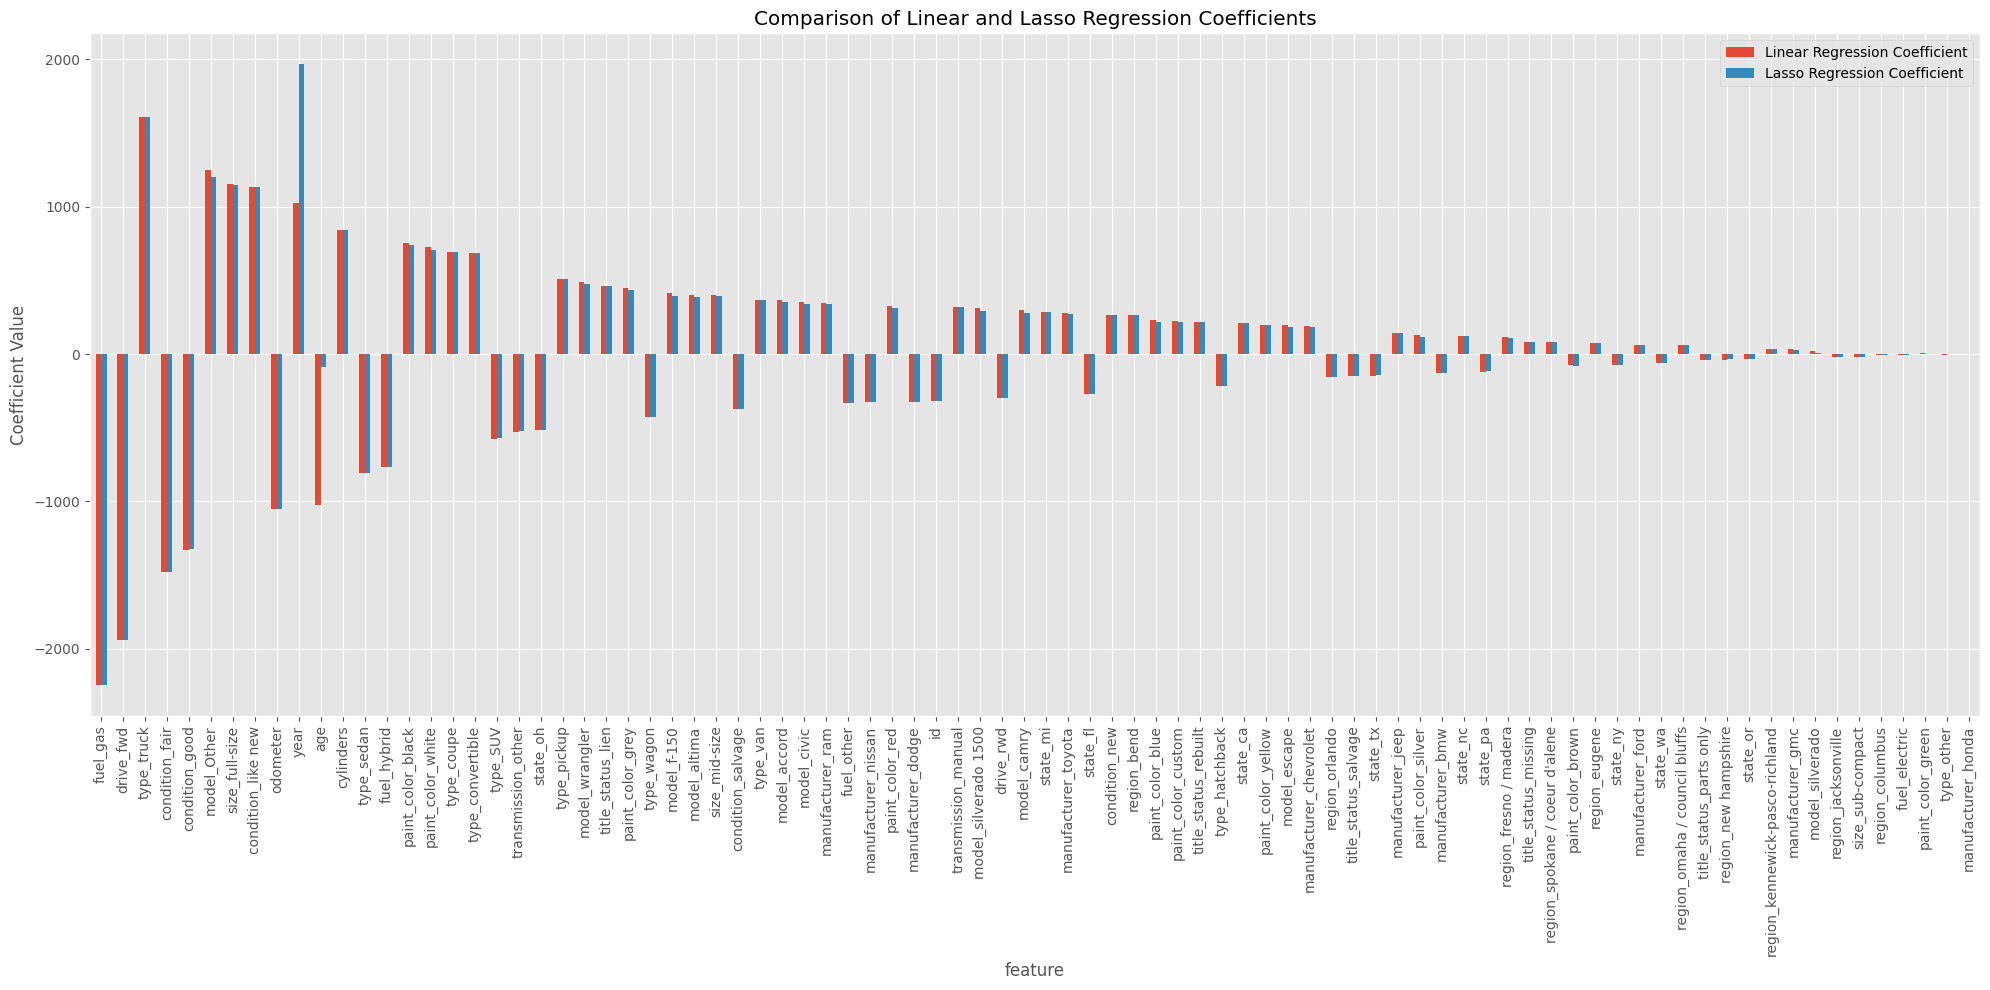

In [105]:
# Coefeceint comparison

# Combine coefficients into a single DataFrame
coefficients_comparison = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'Linear Regression Coefficient': linear_model.coef_,
    'Lasso Regression Coefficient': lasso_model.coef_
})

# Sort by the absolute value of Linear Regression coefficient
coefficients_comparison['Linear Abs'] = np.abs(coefficients_comparison['Linear Regression Coefficient'])
coefficients_comparison = coefficients_comparison.sort_values('Linear Abs', ascending=False).drop(columns='Linear Abs')

print("\nComparison of Coefficients:")
print(coefficients_comparison)

# Visualize the coefficient comparison
plt.figure(figsize=(15, 10))
coefficients_comparison.set_index('feature').plot(kind='bar', figsize=(20, 10))
plt.title('Comparison of Linear and Lasso Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [106]:
# Finding the best alpha value
import os
os.cpu_count()

2

In [107]:
ridge_alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 0, 0.001, 0.005, 0.1, 0.5, 1, 5, 10, 20]

# dictionary
parameters = {'alpha': ridge_alpha}


ridge = Ridge()

# Gridsearch model
ridge_grid = GridSearchCV(ridge, parameters,scoring='neg_mean_squared_error', cv=5, verbose = 3, n_jobs = -1, return_train_score=True)

In [108]:
ridge_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 0,
                                   0.001, 0.005, 0.1, 0.5, 1, 5, 10, 20]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

In [109]:
ridge_grid.best_params_

{'alpha': 20}

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [109]:
# Summerizing the finding



# The first three factors Influencing Used Car Prices are :

# Mileage: The age of the car is a significant negative predictor of price. Older cars with higher mileage tend to have lower prices.
# Condition: While not explicitly analyzed as a separate feature due to potential data limitations or preprocessing steps that grouped similar conditions, the general condition of the vehicle (if captured in other features like `condition` or implied by age and mileage) is expected to be a major driver of price.
 # Manufacturer and Model: Certain manufacturers and specific models consistently command higher prices than others. Identifying the top-performing brands and models in terms of price is crucial for inventory stocking.




# Recommendations for the Used Car Dealership:

 # Prioritize Inventory Based on Key Drivers:** Focus on acquiring cars with lower mileage and in good condition.
# Stock High-Demand Makes and Models:** Identify and prioritize stocking vehicles from the manufacturers and models that were found to have the highest positive impact on price in the analysis.
 # Consider Vehicle Type and Region:** Align inventory with popular vehicle types in your region and consider regional price variations when sourcing vehicles.
 # Leverage Model Insights for Pricing:** Use the developed models as a tool to help estimate the optimal price for incoming vehicles, taking into account their characteristics. While the model provides a prediction, local market knowledge and the specific vehicle's condition should also be considered.

